In [33]:
from enum import Enum
import pandas as pd

import pybcm
from matplotlib import pyplot as plt
from pybcm.config import BCMConfig
from pybcm.rest import RestClient
from pybcm.brick_data import BrickData

In [34]:
config = BCMConfig('../config/bcm.ini')
rc = RestClient(config)
bd = BrickData(config)

Initializing <class 'pybcm.config.BCMConfig'> ../config/bcm.ini


In [35]:
kc = bd.get_known_colors('3006', 'PART')

In [36]:
kc.head()

,quantity,color_name
color_id,,
1,108,White
2,18,Tan
3,76,Yellow
5,190,Red
6,5,Green


In [13]:
from pybcm.legoutils import legoColors

In [15]:
bd.get_part_price_summary('3006', 10)

,item,itemtype,color,new_or_used,currency_code,avg_price,max_price,min_price,qty_avg_price,unit_quantity,total_quantity,sold_or_stock
0,3006,PART,10,N,USD,0.5737,7.33,0.075,0.5141,1004,13339,sold
1,3006,PART,10,U,USD,0.3495,11.95,0.005,0.3152,1477,5284,sold


In [37]:
details = bd.get_part_price_details('3006', 10)
details.head()

,quantity,shipping_available,unit_price
0,1424,True,1.020
1,1148,True,0.785
2,992,True,0.632
3,568,True,0.550
4,451,True,0.990


In [18]:
import seaborn as sns

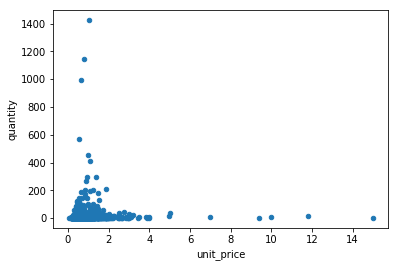

In [38]:
details.plot(x='unit_price', y='quantity', kind='scatter')

In [19]:
from collections import namedtuple

In [20]:
Type = namedtuple('Type', ('PART', 'SET'))

In [21]:
Type._make(('PART', 'SET'))

Type(PART='PART', SET='SET')

In [22]:
from pybcm.const import ItemType

In [23]:
ItemType.PART

'PART'

In [24]:
price_dict = rc.get_price_guide('3006', ItemType.PART, '1', new_or_used='N', guide_type='stock')

In [30]:
prices = pybcm.brick_data._details_df_from_json(price_dict)
len(prices)

1511

In [19]:
import seaborn as sns


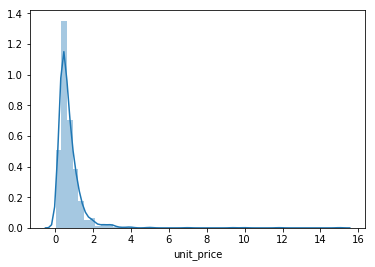

In [20]:
sns.distplot(prices['unit_price'])

In [6]:
cats = bd.get_categories()
cats.head()

,category_id,category_name,parent_id
0,1,Antenna,0
1,2,Baseplate,0
2,3,Boat,0
3,4,Bracket,0
4,5,Brick,0


In [29]:
cats['category_name'][:10]

0            Antenna
1          Baseplate
2               Boat
3            Bracket
4              Brick
5        Brick, Arch
6    Brick, Modified
7       Brick, Round
8             Castle
9          Container
Name: category_name, dtype: object

In [31]:
import os
os.getcwd()

'/Users/Keith/Projects/pybcm_proj/notebooks'

In [94]:
partslist = r'../resources/Sampledata/Cougar_partslist.csv'
pdf = pd.read_csv(partslist, sep='\t', header=0, engine='python', na_values='', skipfooter=3, dtype={'BLItemNo':str, 'BLColorId':int, 'LDrawColorId':int, 'Qty':int})

In [95]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 10 columns):
BLItemNo         128 non-null object
ElementId        126 non-null float64
LdrawId          128 non-null object
PartName         128 non-null object
BLColorId        128 non-null int64
LDrawColorId     128 non-null int64
ColorName        128 non-null object
ColorCategory    128 non-null object
Qty              128 non-null int64
Weight           128 non-null float64
dtypes: float64(2), int64(3), object(5)
memory usage: 10.1+ KB


In [97]:
pdf.fillna({'BLColorId':'', 'Qty':0}).head() 

,BLItemNo,ElementId,LdrawId,PartName,BLColorId,LDrawColorId,ColorName,ColorCategory,Qty,Weight
0,11211,6015344.0,11211,"Brick, Modified 1 x 2 with Studs on 1 Side",86,71,Light Bluish Gray,Solid Colors,3,0.86
1,11212,6015347.0,11212,Plate 3 x 3,86,71,Light Bluish Gray,Solid Colors,2,1.25
2,11458,6019987.0,11458,"Plate, Modified 1 x 2 with Pin Hole on Top",85,72,Dark Bluish Gray,Solid Colors,2,0.47
3,13269,6031790.0,13269,Slope 45 6 x 4 Double / 33 (Train Roof),11,0,Black,Solid Colors,1,3.42
4,15100,6073231.0,15100,"Technic, Pin with Friction Ridges Lengthwise a...",11,0,Black,Solid Colors,2,0.40


In [99]:
(pdf['BLItemNo'] != pdf['LdrawId']).sum()

0

In [102]:
pdf = pdf.rename(mapper={'BLItemNo':'ItemId', 'BLColorId':'Color'}, axis=1)
pdf = pdf.drop(columns=['ElementId', 'LdrawId', 'LDrawColorId'])

In [48]:
pdf.head()

,BLItemNo,ElementId,LdrawId,PartName,BLColorId,LDrawColorId,ColorName,ColorCategory,Qty,Weight
0,11211,6015344,11211,"Brick, Modified 1 x 2 with Studs on 1 Side",86.0,71.0,Light Bluish Gray,Solid Colors,3.0,0.86
1,11212,6015347,11212,Plate 3 x 3,86.0,71.0,Light Bluish Gray,Solid Colors,2.0,1.25
2,11458,6019987,11458,"Plate, Modified 1 x 2 with Pin Hole on Top",85.0,72.0,Dark Bluish Gray,Solid Colors,2.0,0.47
3,13269,6031790,13269,Slope 45 6 x 4 Double / 33 (Train Roof),11.0,0.0,Black,Solid Colors,1.0,3.42
4,15100,6073231,15100,"Technic, Pin with Friction Ridges Lengthwise a...",11.0,0.0,Black,Solid Colors,2.0,0.40


In [43]:
bd.get_known_colors('3003', 'PART')

,quantity,color_name
color_id,,
1,847,White
2,223,Tan
3,680,Yellow
4,148,Orange
5,724,Red
6,330,Green
7,596,Blue
8,23,Brown
9,146,Light Gray


In [41]:
pdf

,BLItemNo,ElementId,LdrawId,PartName,BLColorId,LDrawColorId,ColorName,ColorCategory,Qty,Weight
0,11211,6015344,11211,"Brick, Modified 1 x 2 with Studs on 1 Side",86.0,71.0,Light Bluish Gray,Solid Colors,3.0,0.86
1,11212,6015347,11212,Plate 3 x 3,86.0,71.0,Light Bluish Gray,Solid Colors,2.0,1.25
2,11458,6019987,11458,"Plate, Modified 1 x 2 with Pin Hole on Top",85.0,72.0,Dark Bluish Gray,Solid Colors,2.0,0.47
3,13269,6031790,13269,Slope 45 6 x 4 Double / 33 (Train Roof),11.0,0.0,Black,Solid Colors,1.0,3.42
4,15100,6073231,15100,"Technic, Pin with Friction Ridges Lengthwise a...",11.0,0.0,Black,Solid Colors,2.0,0.40
5,15535,6055313,15535,"Tile, Round 2 x 2 with Hole",85.0,72.0,Dark Bluish Gray,Solid Colors,7.0,0.32
6,15571,6075075,15571,Slope 45 2 x 1 Triple with Bottom Stud Holder,86.0,71.0,Light Bluish Gray,Solid Colors,4.0,0.34
7,2377,4222885,2377,Window 1 x 2 x 2 Plane,86.0,71.0,Light Bluish Gray,Solid Colors,2.0,0.62
8,2412b,241226,2412b,"Tile, Modified 1 x 2 Grille with Bottom Groove...",11.0,0.0,Black,Solid Colors,4.0,0.23
9,2420,4211353,2420,Plate 2 x 2 Corner,86.0,71.0,Light Bluish Gray,Solid Colors,2.0,0.54
